In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}


    df[column_name] = df[column_name].replace(index)

In [3]:
import os
import pandas as pd
import zipfile

# Update this to the correct directory path on your machine
zip_file_path = r'C:\Users\Monster\Downloads\lung_colon_image_set.zip'

# Verify the directory exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"The zip file {zip_file_path} does not exist.")

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # List the contents of the zip file
    file_list = zip_ref.namelist()

# Print the contents of the zip file
print("Contents of the zip file:")
for file in file_list:
    print(file)

# Create lists to store file paths and labels
filepaths = []
labels = []

# Iterate over the files in the zip file
for file in file_list:
    # Extract the folder and file name
    folder, filename = os.path.split(file)
    if 'lung_aca' in folder:
        label = 'Lung Adenocarcinoma'
    elif 'lung_n' in folder:
        label = 'Lung Benign Tissue'
    elif 'lung_scc' in folder:
        label = 'Lung Squamous Cell Carcinoma'
    else:
        # Skip files that are not labeled
        continue
    # Append the file path and label to the lists
    filepaths.append(file)
    labels.append(label)

# Create a DataFrame from the lists
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Print the first few rows of the DataFrame
print(df.head())


Contents of the zip file:
lung_image_sets/lung_aca/lungaca1.jpeg
lung_image_sets/lung_aca/lungaca10.jpeg
lung_image_sets/lung_aca/lungaca100.jpeg
lung_image_sets/lung_aca/lungaca101.jpeg
lung_image_sets/lung_aca/lungaca102.jpeg
lung_image_sets/lung_aca/lungaca103.jpeg
lung_image_sets/lung_aca/lungaca104.jpeg
lung_image_sets/lung_aca/lungaca105.jpeg
lung_image_sets/lung_aca/lungaca106.jpeg
lung_image_sets/lung_aca/lungaca107.jpeg
lung_image_sets/lung_aca/lungaca108.jpeg
lung_image_sets/lung_aca/lungaca109.jpeg
lung_image_sets/lung_aca/lungaca11.jpeg
lung_image_sets/lung_aca/lungaca110.jpeg
lung_image_sets/lung_aca/lungaca111.jpeg
lung_image_sets/lung_aca/lungaca112.jpeg
lung_image_sets/lung_aca/lungaca113.jpeg
lung_image_sets/lung_aca/lungaca114.jpeg
lung_image_sets/lung_aca/lungaca115.jpeg
lung_image_sets/lung_aca/lungaca116.jpeg
lung_image_sets/lung_aca/lungaca117.jpeg
lung_image_sets/lung_aca/lungaca118.jpeg
lung_image_sets/lung_aca/lungaca119.jpeg
lung_image_sets/lung_aca/lungaca12.

In [4]:
df

,filepaths,labels
0,lung_image_sets/lung_aca/lungaca1.jpeg,Lung Adenocarcinoma
1,lung_image_sets/lung_aca/lungaca10.jpeg,Lung Adenocarcinoma
2,lung_image_sets/lung_aca/lungaca100.jpeg,Lung Adenocarcinoma
3,lung_image_sets/lung_aca/lungaca101.jpeg,Lung Adenocarcinoma
4,lung_image_sets/lung_aca/lungaca102.jpeg,Lung Adenocarcinoma
...,...,...
1492,lung_image_sets/lung_scc/lungscc95.jpeg,Lung Squamous Cell Carcinoma
1493,lung_image_sets/lung_scc/lungscc96.jpeg,Lung Squamous Cell Carcinoma
1494,lung_image_sets/lung_scc/lungscc97.jpeg,Lung Squamous Cell Carcinoma
1495,lung_image_sets/lung_scc/lungscc98.jpeg,Lung Squamous Cell Carcinoma


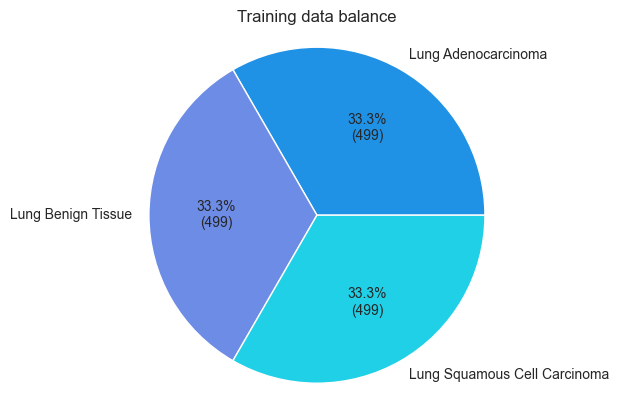

In [5]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()


In [6]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [7]:
import os
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split

# Update this to the correct directory path on your machine
zip_file_path = r'C:\Users\Monster\Downloads\lung_colon_image_set.zip'

# Verify the directory exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"The zip file {zip_file_path} does not exist.")

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # List the contents of the zip file
    file_list = zip_ref.namelist()

# Create lists to store file paths and labels
filepaths = []
labels = []

# Iterate over the files in the zip file
for file in file_list:
    # Extract the folder and file name
    folder, filename = os.path.split(file)
    # Determine the label based on the folder name
    if 'lung_aca' in folder:
        label = 'Lung Adenocarcinoma'
    elif 'lung_n' in folder:
        label = 'Lung Benign Tissue'
    elif 'lung_scc' in folder:
        label = 'Lung Squamous Cell Carcinoma'
    else:
        # Skip files that are not labeled
        continue
    # Append the file path and label to the lists
    filepaths.append(file)
    labels.append(label)

# Create a DataFrame from the lists
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Split the dataset into train, validation, and test sets
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= df['labels'])
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= dummy_df['labels'])

# Print the shapes of the resulting dataframes
print("Train set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)


Train set shape: (1197, 2)
Validation set shape: (150, 2)
Test set shape: (150, 2)


In [8]:
import os
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Bu yolu kendi makinenize göre güncelleyin
zip_file_path = r'C:\Users\Monster\Downloads\lung_colon_image_set.zip'
extract_dir = r'C:\Users\Monster\Downloads\lung_colon_image_set'

# Dizinin var olup olmadığını kontrol edin
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"Zip dosyası {zip_file_path} mevcut değil.")

# Zip dosyasının içeriğini çıkar
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Dosya yollarını ve etiketleri saklamak için listeler oluştur
filepaths = []
labels = []

# Çıkarılan dosyalar içindeki dosya yollarını yineleyin
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            file_path = os.path.join(root, file)

            if 'lung_image_sets' in root:
                if 'lung_aca' in root:
                    label = 'Lung Adenocarcinoma'
                elif 'lung_n' in root:
                    label = 'Lung Benign Tissue'
                elif 'lung_scc' in root:
                    label = 'Lung Squamous Cell Carcinoma'
                else:
                    continue  # Doğru etiketlenmemiş dosyaları atla
            else:
                continue  # İlgili klasörlerde olmayan dosyaları atla
            
            # Dosya yolunu ve etiketi listeye ekle
            filepaths.append(file_path)
            labels.append(label)

# Listelerden bir DataFrame oluştur
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Verisetini eğitim, doğrulama ve test setlerine böl
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])

# Görüntü boyutu
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

# Oluşan veri jeneratörlerinin örnek sayılarını yazdır
print("Eğitim örnek sayısı:", train_gen.samples)
print("Doğrulama örnek sayısı:", valid_gen.samples)
print("Test örnek sayısı:", test_gen.samples)


Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Eğitim örnek sayısı: 12000
Doğrulama örnek sayısı: 1500
Test örnek sayısı: 1500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..236.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

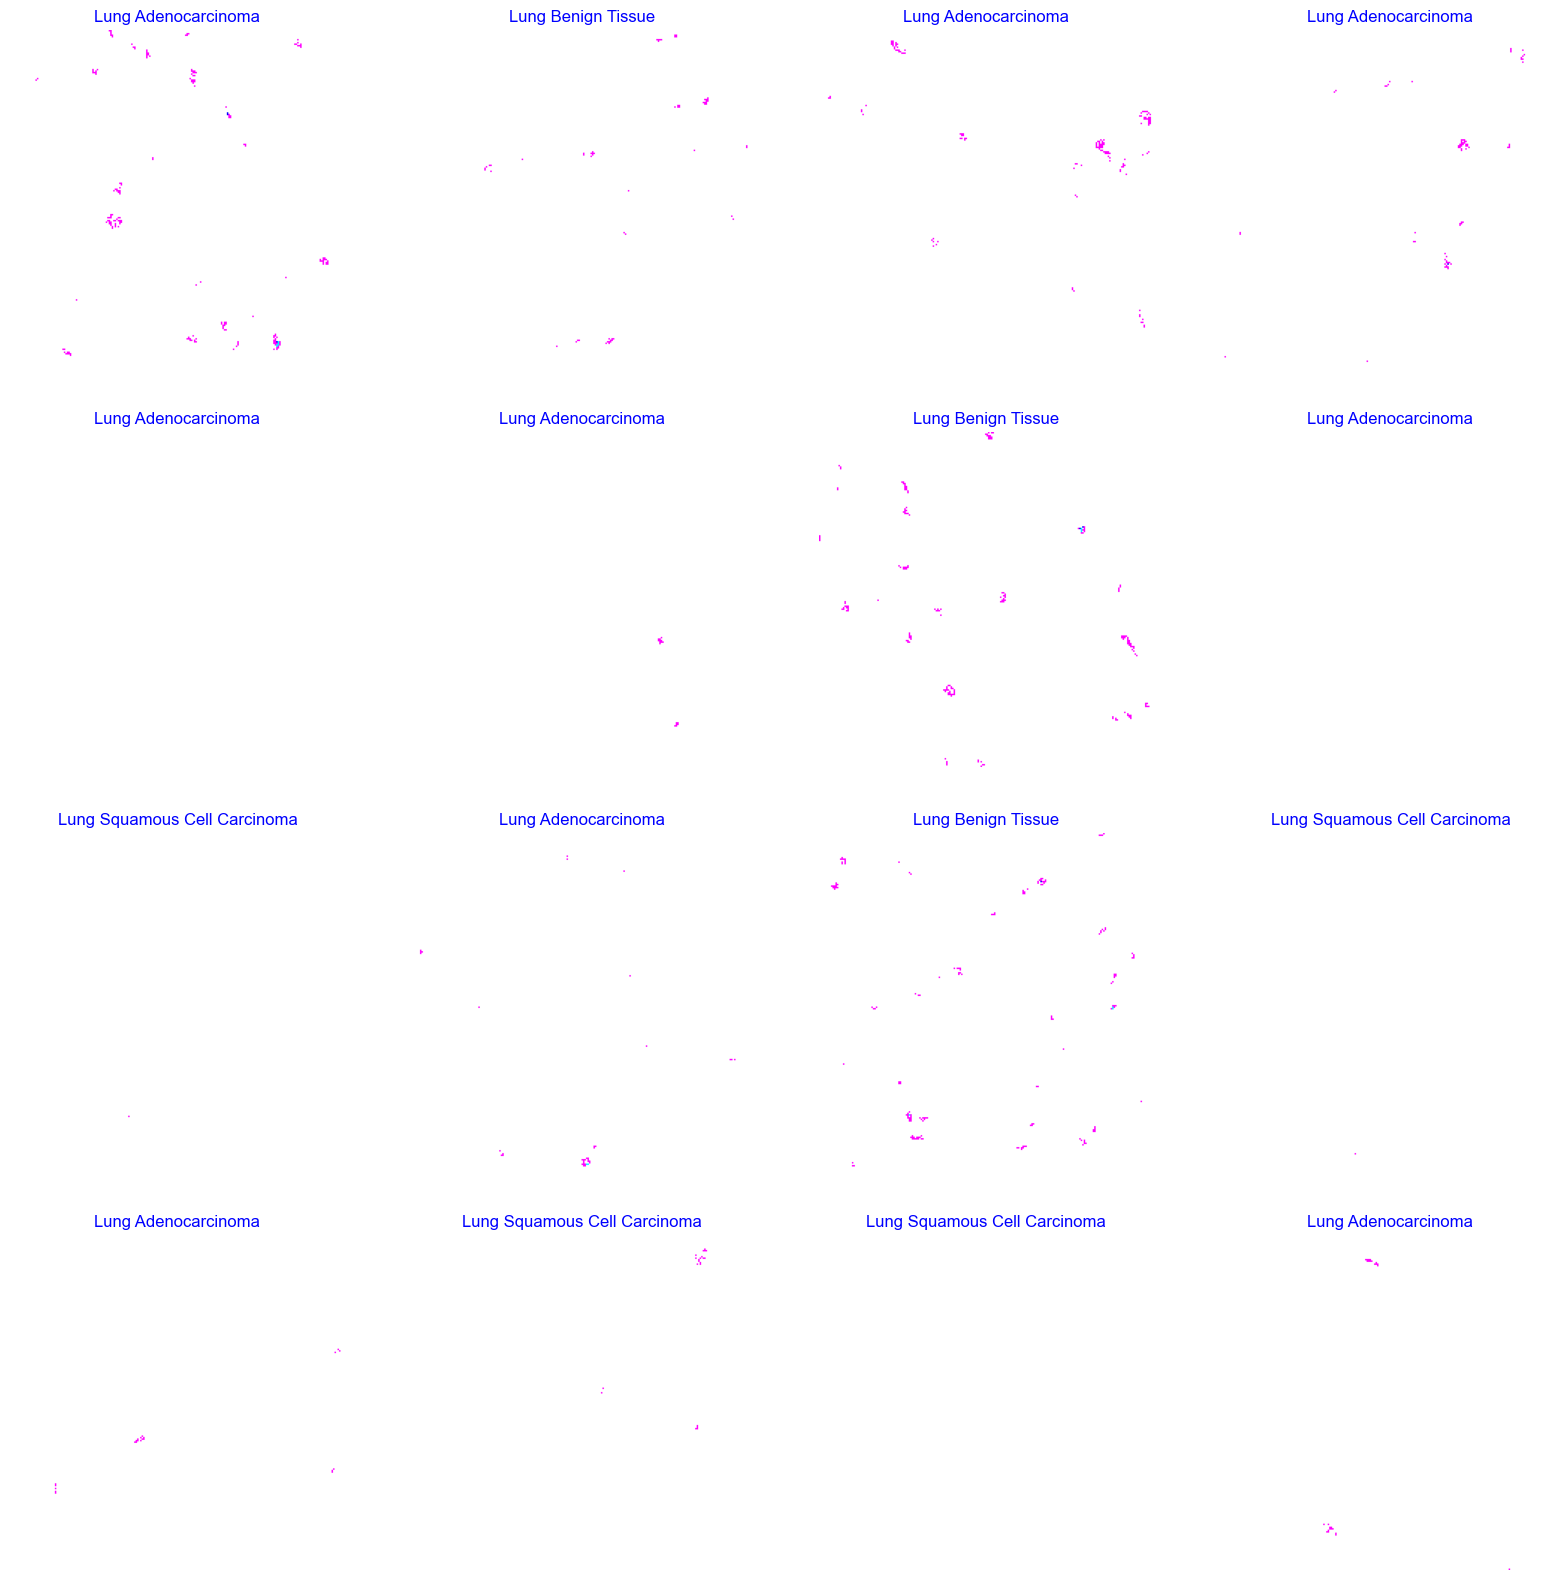

In [9]:
import numpy as np
import matplotlib.pyplot as plt

g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's keys (classes), class names: string
images, labels = next(train_gen)  # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]  # images are already scaled to range (0 - 1)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()


In [10]:
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()
    
    
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [11]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [12]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [13]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128)            │     1,606,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,795,523 (10.66 MB)

 Trainable params: 2,794,083 (10.66 MB)

 Non-trainable params: 1,440 (5.62 KB)

In [14]:
# train the model
epochs = 5  # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False,steps_per_epoch=5)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 68s 13s/step - accuracy: 0.3951 - loss: 1.4337 - val_accuracy: 0.3333 - val_loss: 3.4731
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 12s/step - accuracy: 0.5946 - loss: 1.0461 - val_accuracy: 0.3333 - val_loss: 2.9826
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 52s 12s/step - accuracy: 0.6235 - loss: 0.8827 - val_accuracy: 0.3333 - val_loss: 3.0706
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 48s 11s/step - accuracy: 0.6994 - loss: 0.6892 - val_accuracy: 0.3333 - val_loss: 2.7374
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 51s 12s/step - accuracy: 0.7460 - loss: 0.6392 - val_accuracy: 0.3333 - val_loss: 2.2342


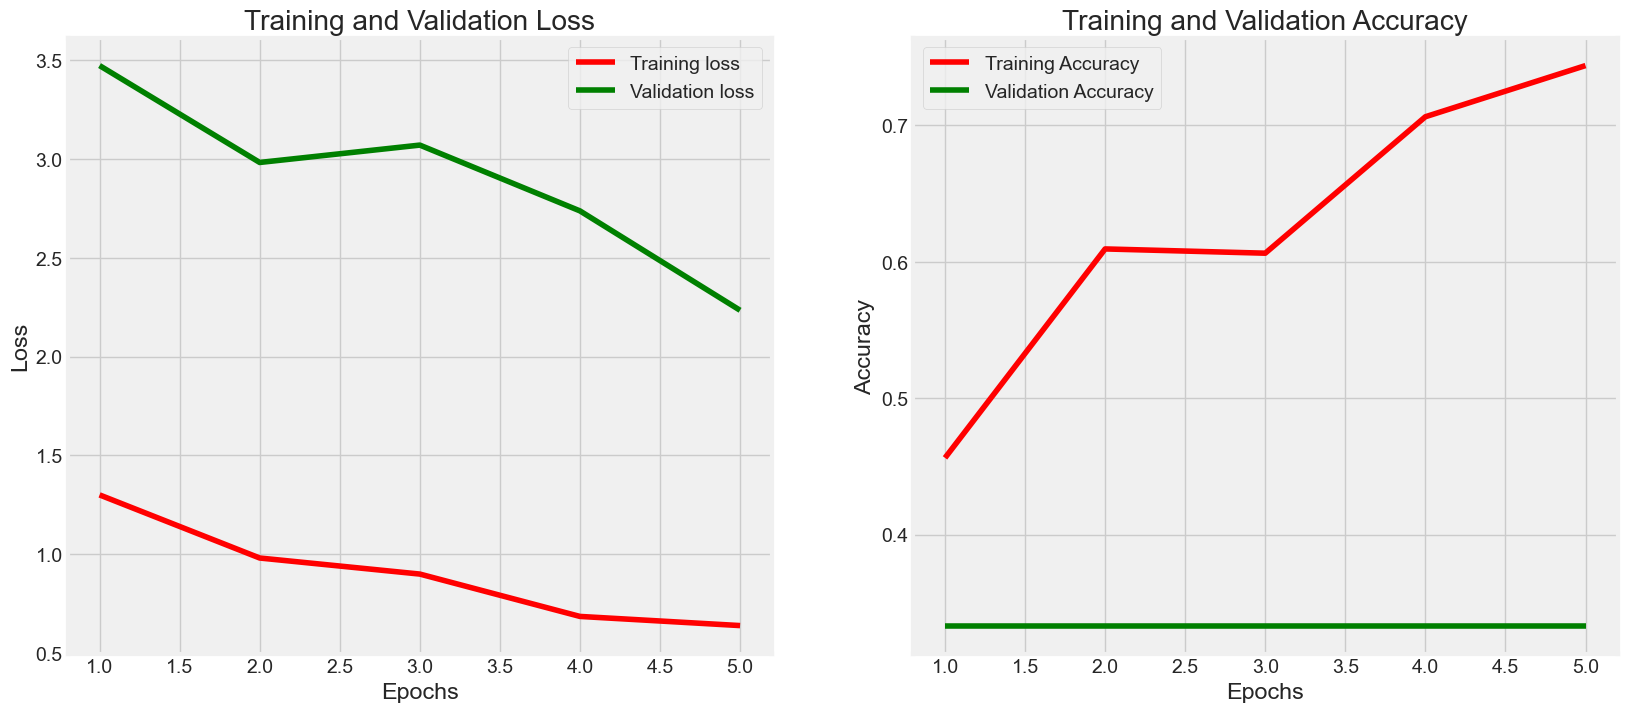

In [15]:
# Display model performance
model_performance(history, epochs)

In [16]:
# Model evaluation
model_evaluation(cnn_model)

188/188 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.3343 - loss: 2.2270
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3376 - loss: 2.2102
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3338 - loss: 2.2399
Train Loss:  2.22709059715271
Train Accuracy:  0.3333333432674408
--------------------
Validation Loss:  2.234196662902832
Validation Accuracy:  0.3333333432674408
--------------------
Test Loss:  2.238626718521118
Test Accuracy:  0.3333333432674408


24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step


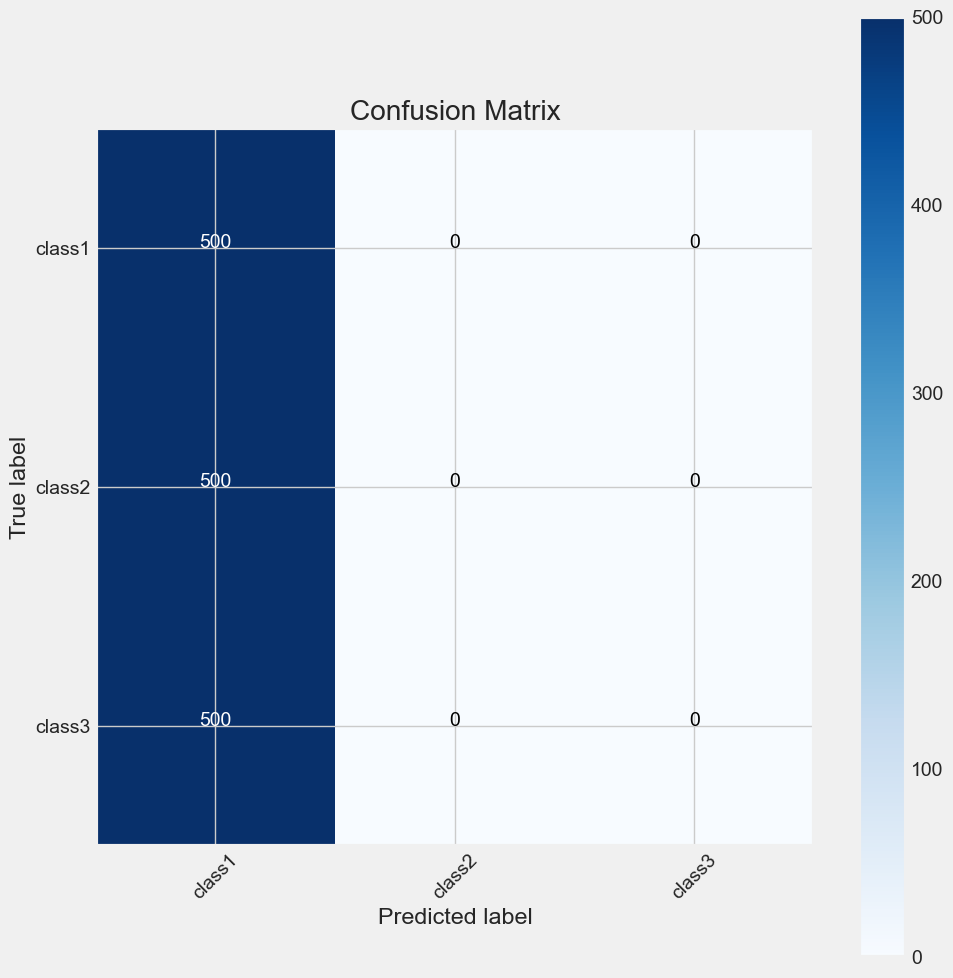

In [17]:
import itertools  # itertools modülünü içe aktarıyoruz
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Diyelim ki bu, get_pred fonksiyonunuz:
def get_pred(model, test_generator):
    # Bu, modelden tahmin almak için bir yer tutucu fonksiyondur.
    # Model ve test veri üretecine bağlı olarak gerçek uygulamanız farklı olabilir.
    return model.predict(test_generator)

# Plot confusion matrix fonksiyonunuz
def plot_confusion_matrix(test_generator, y_pred, classes):
    y_true = test_generator.classes  # Gerçek sınıflar
    
    # Sürekli değerlerden sınıf etiketlerine dönüştürme
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:  # Çok sınıflı problem
        y_pred = np.argmax(y_pred, axis=1)
    else:  # İkili sınıflandırma
        y_pred = (y_pred > 0.5).astype(int)
    
    cm = confusion_matrix(y_true, y_pred)  # Karışıklık matrisi
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Örnek kullanım
# classes değişkenini sınıf isimlerinizle doldurmalısınız
classes = ['class1', 'class2', 'class3']  # Örnek sınıf isimleri

# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred, classes)


In [18]:
# get the pre-trained model (EfficientNetB3)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# fine-tune EfficientNetB3 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

In [19]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,991,282 (41.93 MB)

 Trainable params: 10,900,587 (41.58 MB)

 Non-trainable params: 90,695 (354.28 KB)

In [20]:
# Classification report
# Tahmin edilen sınıfların endekslerini alın
y_pred_argmax = np.argmax(y_pred, axis=1)

# Sınıf isimlerini alın
class_names = list(test_gen.class_indices.keys())

# Sınıflandırma raporunu oluşturun
print(classification_report(test_gen.classes, y_pred_argmax, target_names=class_names))


                              precision    recall  f1-score   support

         Lung Adenocarcinoma       0.33      1.00      0.50       500
          Lung Benign Tissue       0.00      0.00      0.00       500
Lung Squamous Cell Carcinoma       0.00      0.00      0.00       500

                    accuracy                           0.33      1500
                   macro avg       0.11      0.33      0.17      1500
                weighted avg       0.11      0.33      0.17      1500



In [21]:
#Save the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Giriş şeklini ve sınıf sayısını belirtin
input_shape = (img_size[0], img_size[1], channels)
num_classes = len(train_gen.class_indices)

# Modeli oluşturun
model = create_model(input_shape, num_classes)

# Modeli eğitin
epochs = 5
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen,steps_per_epoch=5)

# Modeli kaydedin
model.save('Model.h5')


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.3940 - loss: 3630.1746 - val_accuracy: 0.3333 - val_loss: 702.3467
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 7s/step - accuracy: 0.3828 - loss: 492.9807 - val_accuracy: 0.3760 - val_loss: 534.1068
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.4644 - loss: 304.4272 - val_accuracy: 0.6333 - val_loss: 8.6588
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.6845 - loss: 4.8401 - val_accuracy: 0.6500 - val_loss: 0.9687
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - accuracy: 0.6360 - loss: 1.2080 - val_accuracy: 0.6553 - val_loss: 0.7851


In [22]:
loaded_model = tf.keras.models.load_model("C:/Users/Monster/Desktop/Model.h5", compile=False)
loaded_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
from PIL import Image

image_path = r'C:\Users\Monster\AppData\Local\Temp\75f9d9d7-284f-40c1-8240-ee67300b0755_lung_colon_image_set.zip.755\lung_image_sets\lung_n\lungn329.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
class2
